Train specified model.

LSTM model architecture and design inspired by [Alcantara et al.](https://peerj.com/articles/12752)

# Input parameters here

In [1]:
# # PARAMETERS # #
BASE_DIR = '/content/drive/My Drive/CS230_FinalReport/' # your base directory
EXP_TYPE = 'with_physicsinputs'

# Hyperparameters:
LSTM_NODES = 448
DROPOUT_RATE = 0.5
LEARNING_RATE = 0.01

MASK_VALUE = 999.
MAX_TIMESTEPS = 112
if EXP_TYPE == 'with_physicsinputs': NUM_INPUT_FEATS = 36
if EXP_TYPE == 'without_physicsinputs': NUM_INPUT_FEATS = 28
MODEL_FILENAME = '/content/drive/My Drive/CS230_FinalReport/models/' + EXP_TYPE + '_lstm_interoutputs_fixclass' # where you want to save the model to
BATCH_SIZE = 32
EPOCHS = 100

SEED = 43
# # # # # # # # # #

# Load libraries and data

In [2]:
# Mount Drive to access data.
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
# Library imports
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io as sio
import numpy as np
import os

# To import own model modules
import sys
sys.path.insert(0, (os.path.join(BASE_DIR, 'src/models')))
from train_model_utils_lstm_interoutputs import *

In [4]:
# Set the random seed
keras.utils.set_random_seed(SEED)

In [5]:
# Load in train, dev, arrays.
datadir = os.path.join(BASE_DIR, 'data', 'processed', 'normalized')

X_train = np.load(file=os.path.join(datadir, EXP_TYPE, 'X_train_norm_100Hz_RawDist.npy'), allow_pickle=True)
Y_train = np.load(file=os.path.join(datadir, EXP_TYPE, 'Y_train_norm_100Hz_RawDist_InterOutputs.npy'), allow_pickle=True)
X_dev = np.load(file=os.path.join(datadir, EXP_TYPE, 'X_dev_norm_100Hz_RawDist.npy'), allow_pickle=True)
Y_dev = np.load(file=os.path.join(datadir, EXP_TYPE, 'Y_dev_norm_100Hz_RawDist_InterOutputs.npy'), allow_pickle=True)

# Check sizes
print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_dev: {X_dev.shape}")
print(f"Y_dev: {Y_dev.shape}")

X_train: (5949, 112, 36)
Y_train: (5949, 112, 14)
X_dev: (820, 112, 36)
Y_dev: (820, 112, 14)


In [6]:
# Create new Y data structs for new model architecture.

# Train:
Y_train_total_grf = Y_train[:,:,0:3]
Y_train_class_r = np.expand_dims(Y_train[:,:,3], axis=-1)
Y_train_class_l = np.expand_dims(Y_train[:,:,4], axis=-1)
Y_train_dist_r = Y_train[:,:,5:8]
Y_train_grf_r = Y_train[:,:,8:11]
Y_train_grf_l = Y_train[:,:,11:]

# Repeat for dev:
Y_dev_total_grf = Y_dev[:,:,0:3]
Y_dev_class_r = np.expand_dims(Y_dev[:,:,3], axis=-1)
Y_dev_class_l = np.expand_dims(Y_dev[:,:,4], axis=-1)
Y_dev_dist_r = Y_dev[:,:,5:8]
Y_dev_grf_r = Y_dev[:,:,8:11]
Y_dev_grf_l = Y_dev[:,:,11:]

# Train the model

In [7]:
# Call build model with selected parameters.

model = build_model(
    NUM_TIMESTEPS = MAX_TIMESTEPS,
    NUM_INPUT_FEATS = NUM_INPUT_FEATS,
    MASK_VALUE = MASK_VALUE,
    SEED = SEED,
    lstm_nodes = LSTM_NODES,
    lstm_act = 'tanh',
    dropout_rate = DROPOUT_RATE,
    learning_rate = LEARNING_RATE)

# Print a summary of the model's layers and all the parameters.
model.summary()

Model: "LSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 36)]    0           []                               
                                                                                                  
 masking (Masking)              (None, 112, 36)      0           ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 112, 448)     1738240     ['masking[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 112, 448)     0           ['bidirectional[0][0]']          
                                                                                               

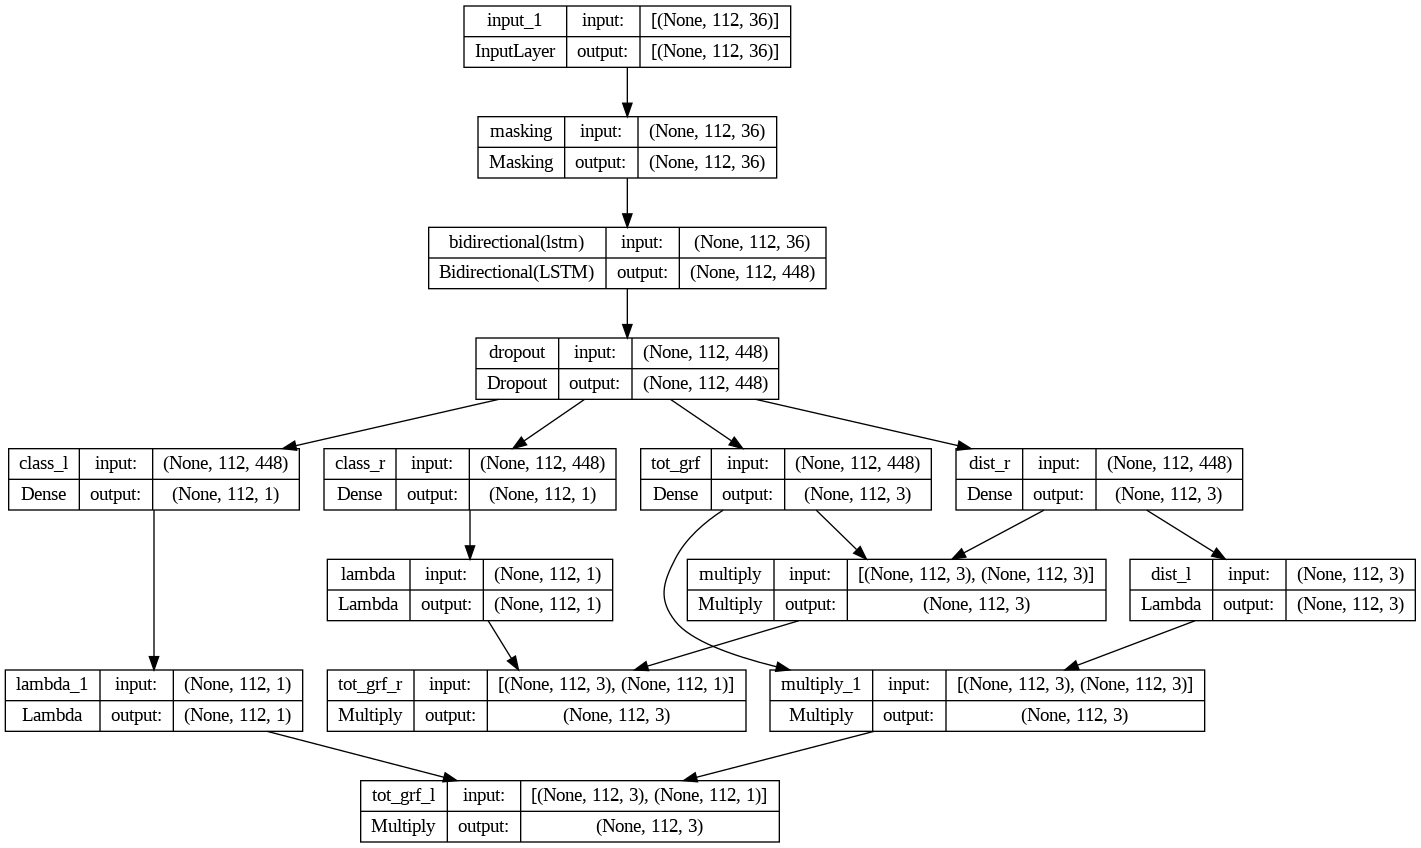

In [8]:
keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [9]:
# Train the model, and get the fit history.

fit_history = train_model(model,
            MODEL_FILENAME,
            X_train, Y_train_total_grf, Y_train_class_r, Y_train_class_l, Y_train_dist_r, Y_train_grf_r, Y_train_grf_l,
            X_dev, Y_dev_total_grf, Y_dev_class_r, Y_dev_class_l, Y_dev_dist_r, Y_dev_grf_r, Y_dev_grf_l,
            use_earlystopping = False,
            shuffle = True,
            epochs = EPOCHS,
            batch_size = BATCH_SIZE)

# Save fit history.
np.save(os.path.join(MODEL_FILENAME, 'fit_history.npy'), fit_history.history)

Epoch 1/100


186/186 [==============================] - ETA: 0s - loss: 1.5288 - tot_grf_loss: 0.3897 - class_r_loss: 0.0351 - class_l_loss: 0.0479 - dist_r_loss: 0.0310 - tot_grf_r_loss: 0.5419 - tot_grf_l_loss: 0.4833 - tot_grf_root_mean_squared_error: 0.6231 - class_r_binary_accuracy: 0.9866 - class_l_binary_accuracy: 0.9806 - dist_r_root_mean_squared_error: 0.1760 - tot_grf_r_root_mean_squared_error: 0.7348 - tot_grf_l_root_mean_squared_error: 0.6942
Epoch 1: val_loss improved from inf to 1.75779, saving model to /content/drive/My Drive/CS230_FinalReport/models/with_physicsinputs_lstm_interoutputs_fixclass


186/186 [==============================] - 59s 276ms/step - loss: 1.5288 - tot_grf_loss: 0.3897 - class_r_loss: 0.0351 - class_l_loss: 0.0479 - dist_r_loss: 0.0310 - tot_grf_r_loss: 0.5419 - tot_grf_l_loss: 0.4833 - tot_grf_root_mean_squared_error: 0.6231 - class_r_binary_accuracy: 0.9866 - class_l_binary_accuracy: 0.9806 - dist_r_root_mean_squared_error: 0.1760 - tot_grf_r_root_mean_squared_error: 0.7348 - tot_grf_l_root_mean_squared_error: 0.6942 - val_loss: 1.7578 - val_tot_grf_loss: 0.5020 - val_class_r_loss: 0.0163 - val_class_l_loss: 0.0291 - val_dist_r_loss: 0.0230 - val_tot_grf_r_loss: 0.6555 - val_tot_grf_l_loss: 0.5319 - val_tot_grf_root_mean_squared_error: 0.6354 - val_class_r_binary_accuracy: 0.9938 - val_class_l_binary_accuracy: 0.9888 - val_dist_r_root_mean_squared_error: 0.1532 - val_tot_grf_r_root_mean_squared_error: 0.7465 - val_tot_grf_l_root_mean_squared_error: 0.6844
Epoch 2/100
186/186 [==============================] - ETA: 0s - loss: 1.1344 - tot_grf_loss: 0.2629

186/186 [==============================] - 51s 272ms/step - loss: 1.1344 - tot_grf_loss: 0.2629 - class_r_loss: 0.0113 - class_l_loss: 0.0198 - dist_r_loss: 0.0249 - tot_grf_r_loss: 0.4268 - tot_grf_l_loss: 0.3888 - tot_grf_root_mean_squared_error: 0.5121 - class_r_binary_accuracy: 0.9958 - class_l_binary_accuracy: 0.9929 - dist_r_root_mean_squared_error: 0.1578 - tot_grf_r_root_mean_squared_error: 0.6530 - tot_grf_l_root_mean_squared_error: 0.6232 - val_loss: 1.6579 - val_tot_grf_loss: 0.4303 - val_class_r_loss: 0.0169 - val_class_l_loss: 0.0294 - val_dist_r_loss: 0.0264 - val_tot_grf_r_loss: 0.6052 - val_tot_grf_l_loss: 0.5497 - val_tot_grf_root_mean_squared_error: 0.5888 - val_class_r_binary_accuracy: 0.9938 - val_class_l_binary_accuracy: 0.9884 - val_dist_r_root_mean_squared_error: 0.1628 - val_tot_grf_r_root_mean_squared_error: 0.7207 - val_tot_grf_l_root_mean_squared_error: 0.6956
Epoch 3/100
186/186 [==============================] - ETA: 0s - loss: 1.0790 - tot_grf_loss: 0.2445

186/186 [==============================] - 50s 267ms/step - loss: 1.0223 - tot_grf_loss: 0.2288 - class_r_loss: 0.0077 - class_l_loss: 0.0140 - dist_r_loss: 0.0270 - tot_grf_r_loss: 0.3958 - tot_grf_l_loss: 0.3488 - tot_grf_root_mean_squared_error: 0.4777 - class_r_binary_accuracy: 0.9971 - class_l_binary_accuracy: 0.9948 - dist_r_root_mean_squared_error: 0.1643 - tot_grf_r_root_mean_squared_error: 0.6285 - tot_grf_l_root_mean_squared_error: 0.5903 - val_loss: 1.5998 - val_tot_grf_loss: 0.4270 - val_class_r_loss: 0.0191 - val_class_l_loss: 0.0271 - val_dist_r_loss: 0.0301 - val_tot_grf_r_loss: 0.6227 - val_tot_grf_l_loss: 0.4739 - val_tot_grf_root_mean_squared_error: 0.5922 - val_class_r_binary_accuracy: 0.9947 - val_class_l_binary_accuracy: 0.9902 - val_dist_r_root_mean_squared_error: 0.1731 - val_tot_grf_r_root_mean_squared_error: 0.7262 - val_tot_grf_l_root_mean_squared_error: 0.6533
Epoch 6/100
186/186 [==============================] - ETA: 0s - loss: 0.9984 - tot_grf_loss: 0.2212

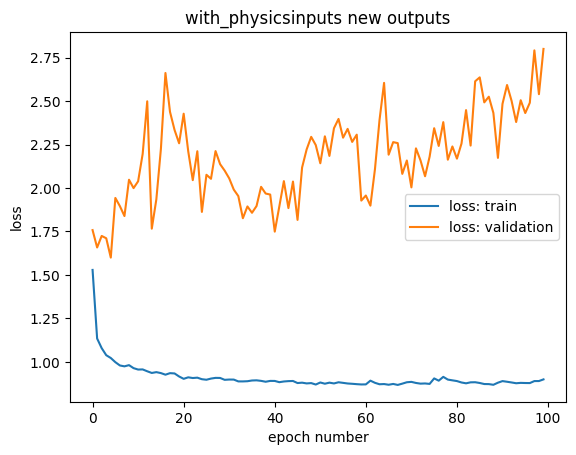

In [10]:
# Plot train/validation loss across epochs.
fit_history = np.load(os.path.join('/content/drive/My Drive/CS230_FinalReport/models/' + EXP_TYPE + '_lstm_interoutputs_fixclass', 'fit_history.npy') , allow_pickle = True)
fit_history = fit_history.tolist()
plot_title = (EXP_TYPE + ' new outputs')
save_dir = os.path.join(BASE_DIR, 'reports', 'figures', EXP_TYPE + "_lstm_interoutputs", 'training_loss.png')

plt.plot(fit_history['loss'], label='loss: train')
plt.plot(fit_history['val_loss'], label='loss: validation')
plt.ylabel('loss')
plt.xlabel('epoch number')
plt.title(plot_title)
plt.legend()
plt.savefig(save_dir)

plt.show()

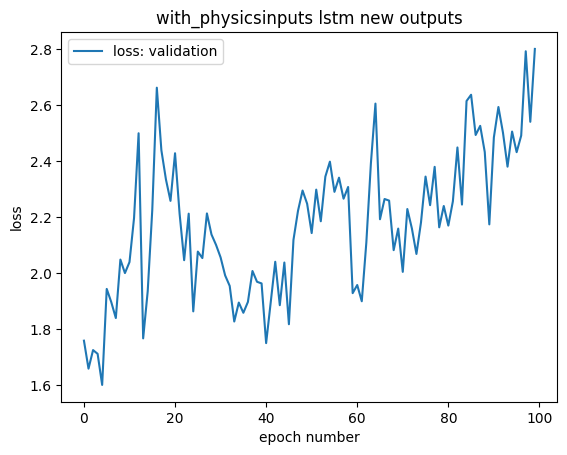

In [11]:
plt.plot(fit_history['val_loss'], label='loss: validation')
plot_title = (EXP_TYPE + ' lstm new outputs')
save_dir = os.path.join(BASE_DIR, 'reports', 'figures', EXP_TYPE + "_lstm_interoutputs_fixclass", 'training_loss_validationloss.png')

plt.ylabel('loss')
plt.xlabel('epoch number')
plt.title(plot_title)
plt.legend()
plt.savefig(save_dir)

plt.show()